In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

In [3]:

df= pd.read_csv('customer_ret.csv')
df.drop(['Customer','State'], axis = 1, inplace = True)# remove uneccesary variables
df.head()

,Customer Lifetime Value,Coverage,Education,Effective months,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,...,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size,Response
0,2763.519279,Basic,Bachelor,141,Employed,F,56274,Suburban,Married,69,...,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize,No
1,6979.535903,Extended,Bachelor,142,Unemployed,F,0,Suburban,Single,94,...,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize,No
2,12887.431650,Premium,Bachelor,141,Employed,F,48767,Suburban,Married,108,...,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize,No
3,7645.861827,Basic,Bachelor,142,Unemployed,M,0,Suburban,Married,106,...,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize,No
4,2813.692575,Basic,Bachelor,141,Employed,M,43836,Rural,Single,73,...,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize,No


In [68]:
(sum(df['Response'] == 'No')/(df['Response'].count()))*100
# 85% are not retained

85.67987738121306

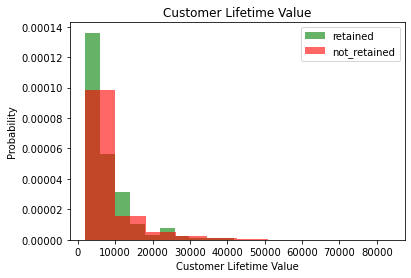

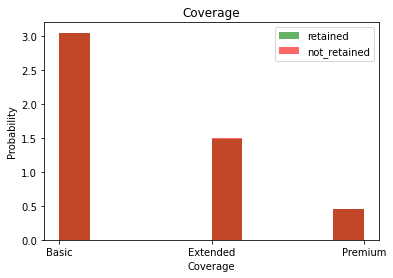

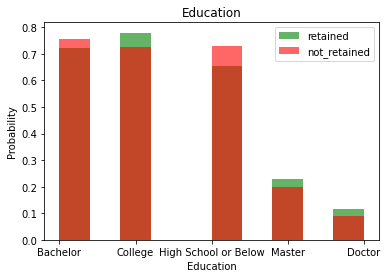

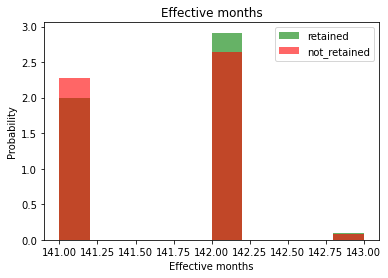

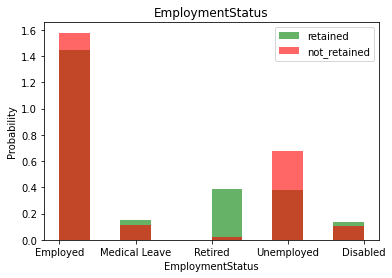

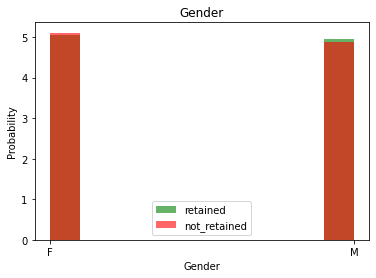

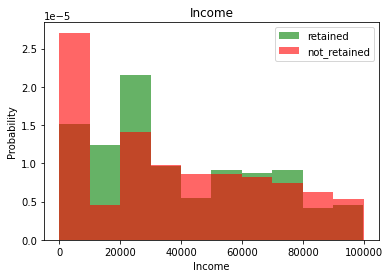

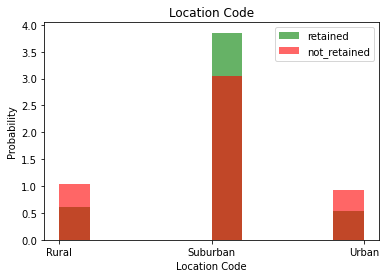

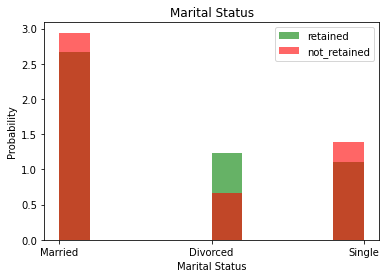

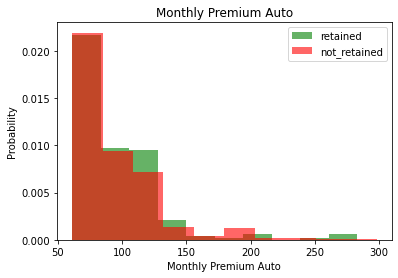

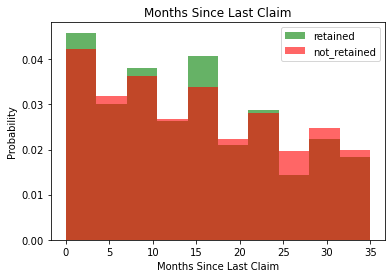

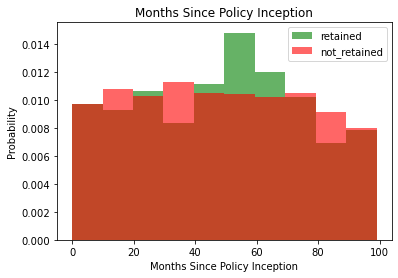

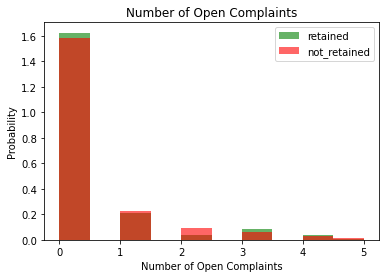

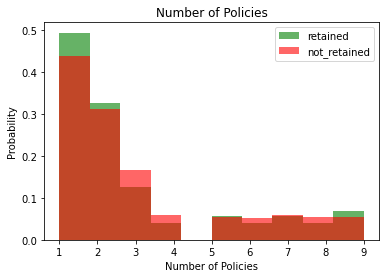

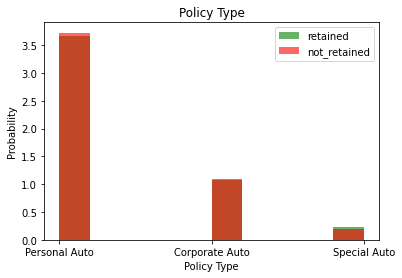

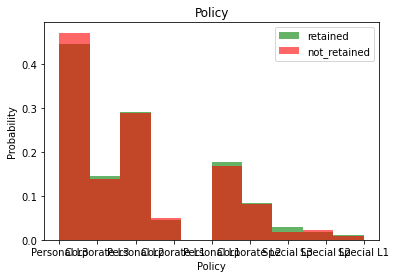

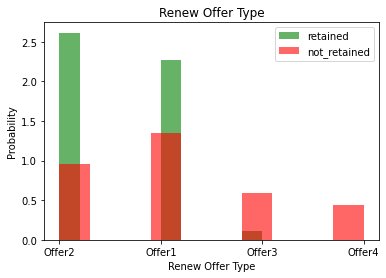

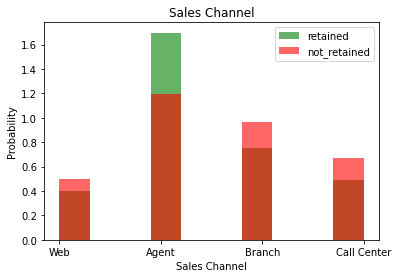

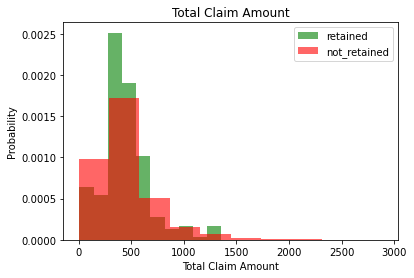

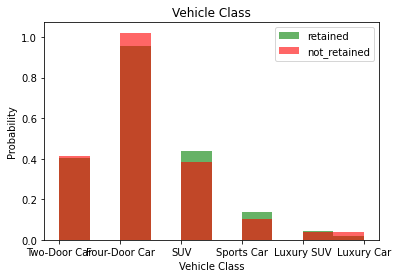

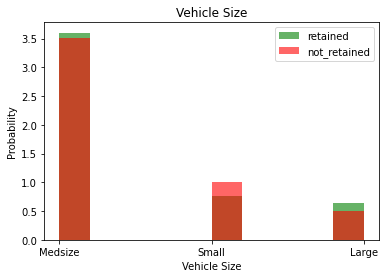

In [4]:
#plot variables against probability/frequency to study the cause
# We take equal samples from each class( Retained, not retained) to ensure we don't get baias results
for label in df.columns[:-1]:
    plt.hist(df[df['Response']=="Yes" ][label], color='Green', label='retained',alpha = 0.6,density=True) #desity being true to normalise the distribution
    plt.hist(df[df['Response']=="No" ][label], color='Red', label='not_retained',alpha = 0.6,density=True)
    plt.title(label)
    plt.ylabel('Probability')
    plt.xlabel(label)
    plt.legend()
    plt.show()

### Factors that affect customer retention
From the graphs above, it is clear that the main factors that influence customer retention are the ff :
* Total Claim amount
* Income being too low
* Employment status
* Offer being renewed over and over again
* Months since last claim

### Total Claim amount and Months not claiming

In [43]:
# lets see the percentage of customers who made a claim of less than $1500 and then left
not_retained = df[df['Response'] == "No"]
(sum(not_retained['Total Claim Amount'] < 1500)/not_retained['Total Claim Amount'].count())*100



99.15665729619218

In [41]:
# morethan $1500 and remained
retained = df[df['Response'] == "Yes"]
(sum(retained['Total Claim Amount'] > 1500)/retained['Total Claim Amount'].count())*100 

0.0

Obsarvations
* From the graphs we notice that the longer people stay without making a claim, the greater the chances of them cancelling the policy
* From the analysis we also notice that the customers who made a caim of more than $1500 were all remain.



### Income

In [7]:
income = df[df['Income'] != 0] # income description for all customers
income['Income'].describe()

count     6817.000000
mean     50456.580461
std      24305.956566
min      10037.000000
25%      28432.000000
50%      48081.000000
75%      70187.000000
max      99981.000000
Name: Income, dtype: float64

In [8]:
# percentage of customeres who recieve some sort of income but fall below the mean salary who were not retained.
income2 = not_retained[not_retained['Income'] !=0 ] # and recieve some sort of income
(sum(income2['Income'] <50456)/income2['Income'].count())*100

51.42807079025757

In [9]:
# percentage of :

income3 = retained[retained['Income'] !=0 ] # recieve some sort of income
(sum(income3['Income'] <50456)/income3['Income'].count())*100 # but fall below the mean, is almost 60%
# These results imply that cusomers who were retained are not neccesarily richcer that thos who weren't



58.37837837837838

### Monthly premium and Income

In [10]:
not_retained['Monthly Premium Auto'].describe() # Monthly premiums for customers who were not retained

count    7826.00000
mean       93.06504
std        34.08021
min        61.00000
25%        68.00000
50%        82.00000
75%       109.00000
max       298.00000
Name: Monthly Premium Auto, dtype: float64

In [11]:
retained = df[df['Response'] =="Yes"] # Monthly premiums for customers who were retained
retained['Monthly Premium Auto'].describe()


count    1308.000000
mean       94.142202
std        36.307194
min        61.000000
25%        68.000000
50%        85.500000
75%       109.000000
max       283.000000
Name: Monthly Premium Auto, dtype: float64

I though these results would be different and the customers who left the policy were charged more, now we see that is not the case.
Their monthly premium is pretty much the same, therefore it's not a factor.

##### Now we group them by their salary and try to estemate the premium that each group is willing to pay, beyond which they may want to leave the policy

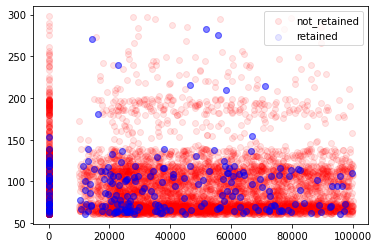

In [12]:
fig, ax = plt.subplots()
ax.scatter(not_retained['Income'] , not_retained['Monthly Premium Auto'], color='Red', label='not_retained',alpha=0.1)
ax.scatter(retained['Income'] ,retained['Monthly Premium Auto'], color='Blue', label='retained',alpha = 0.1)
plt.legend()
plt.show()

# We dont see any clear distinction between these two groups from this graph


In [15]:
# we group them by their income and calculate the mean premium for each group
def group_mean(dataframe,group):

    meanprem = []
    def mean_prem(Range1,Range2):
        prem_inc = dataframe[np.logical_and(dataframe["Income"]>Range1,dataframe["Income"] <Range2)]
        return prem_inc['Monthly Premium Auto'].mean()
    income_range = []
    for i in range(10000,102000,1000):
        income_range.append(i)

    MeanPrem = []
    for n in range(0,len(income_range)-1):
        Prem = mean_prem(income_range[n],income_range[n+1])
        MeanPrem.append(Prem)
        r = {"Income_group":income_range[n],f"mean_prem-{group}":MeanPrem[n]}
        meanprem.append(r)
    mean_premiums = pd.DataFrame(data = meanprem)
    return mean_premiums

group_mean(df,"all").head()



,Income_group,mean_prem-all
0,10000,86.317073
1,11000,90.217391
2,12000,93.928571
3,13000,96.313725
4,14000,108.754717


In [16]:
not_retained_group = group_mean(not_retained,"Not_Retained").dropna() # mean premium for the group that cancelled the policy on different salaries
retained_group = group_mean(retained,"Retained").dropna()

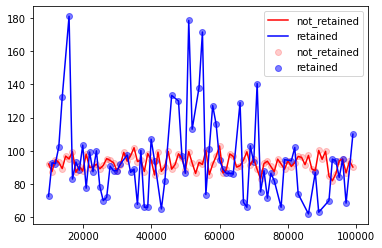

In [17]:
fig, ax = plt.subplots()
ax.scatter(not_retained_group['Income_group'] , not_retained_group['mean_prem-Not_Retained'], color='Red', label='not_retained',alpha = 0.2)
ax.scatter(retained_group['Income_group'] ,retained_group['mean_prem-Retained'], color='Blue', label='retained',alpha = 0.5)
ax.plot(not_retained_group['Income_group'] , not_retained_group['mean_prem-Not_Retained'], color='Red', label='not_retained')
ax.plot(retained_group['Income_group'] ,retained_group['mean_prem-Retained'], color='Blue', label='retained')
plt.legend()
plt.show()

#### Observations
* From this graph now we notice that most people who remained are aither paying an equal or less premium on average compared to this that left.
* We also notice that if a person earns more money, that not neccesarily mean they will be willing to pay more on uto premium

### Customer Life Values and Monthly Premiums

In [127]:
import plotly.express as px
px.scatter(x=df['Customer Lifetime Value'] ,y=df['Monthly Premium Auto'], color = df['Response'])

#### Now lets see the group mean

In [19]:
def group_mean(dataframe,group):

    meanprem = []
    def mean_prem(Range1,Range2):
        prem_inc = dataframe[np.logical_and(dataframe["Customer Lifetime Value"]>Range1,dataframe["Customer Lifetime Value"] <Range2)]
        return prem_inc['Monthly Premium Auto'].mean()
    CLV_range = []
    for i in range(10000,102000,1000):
        CLV_range.append(i)

    MeanPrem = []
    for n in range(0,len(CLV_range)-1):
        Prem = mean_prem(CLV_range[n],CLV_range[n+1])
        MeanPrem.append(Prem)
        r = {"CLV_group":CLV_range[n],f"mean_prem-{group}":MeanPrem[n]}
        meanprem.append(r)
    mean_premiums = pd.DataFrame(data = meanprem)
    return mean_premiums

group_mean(df,"all").head()

,CLV_group,mean_prem-all
0,10000,117.098485
1,11000,111.573099
2,12000,110.105882
3,13000,122.169492
4,14000,121.578947


In [20]:
not_retained_group = group_mean(not_retained,"Not_Retained").dropna() # mean premium for the group that cancelled the policy on different salaries
retained_group = group_mean(retained,"Retained").dropna()

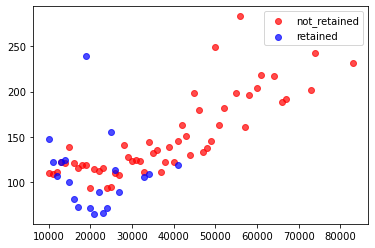

In [25]:
plt.scatter(not_retained_group['CLV_group'] , not_retained_group['mean_prem-Not_Retained'], color='Red', label='not_retained',alpha = 0.7)
plt.scatter(retained_group['CLV_group'] ,retained_group['mean_prem-Retained'], color='Blue', label='retained',alpha = 0.7)
plt.legend()
plt.show()

observations
* From the graph we notice that customers who were not retained have higher 'Customer Lifetime Value' on average.
* As a matter of fact, there's a great chance that people who spend more than $30000 will cancel the policy eventually
* Monthly premiums are strongly correlated to the 'Customer Lifetime Values'

### "Customer Lifetime Value" and Total Claim Amount

In [29]:
df["Total Claim Amount"].describe()

count    9134.000000
mean      434.088794
std       290.500092
min         0.099007
25%       272.258244
50%       383.945434
75%       547.514839
max      2893.239678
Name: Total Claim Amount, dtype: float64

In [36]:
def group_mean(dataframe,group):

    meanclv = []
    def mean_prem(Range1,Range2):
        prem_inc = dataframe[np.logical_and(dataframe["Total Claim Amount"]>Range1,dataframe["Total Claim Amount"] <Range2)]
        return prem_inc['Customer Lifetime Value'].mean()
    tca_range = []
    for i in range(0,3100,100):
        tca_range.append(i)

    MeanCLV = []
    for n in range(0,len(tca_range)-1):
        tca = mean_prem(tca_range[n],tca_range[n+1])
        MeanCLV.append(tca)
        r = {"tca_group":tca_range[n],f"mean_CLV-{group}":MeanCLV[n]}
        meanclv.append(r)
    mean_tca = pd.DataFrame(data = meanclv)
    return mean_tca

group_mean(df,"all").head()

,tca_group,mean_CLV-all
0,0,7211.478238
1,100,7432.896228
2,200,6976.487961
3,300,6526.102012
4,400,7751.819252


In [37]:
not_retained_group = group_mean(not_retained,"Not_Retained").dropna() 
retained_group = group_mean(retained,"Retained").dropna()

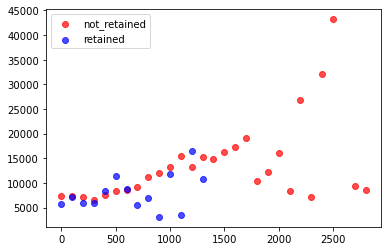

In [38]:
plt.scatter(not_retained_group['tca_group'] , not_retained_group['mean_CLV-Not_Retained'], color='Red', label='not_retained',alpha = 0.7)
plt.scatter(retained_group['tca_group'] ,retained_group['mean_CLV-Retained'], color='Blue', label='retained',alpha = 0.7)
plt.legend()
plt.show()

This graph further confirms our anaysis that all customers who made claims of morethan $1500 were not retained.s

### Preparing data for Model fitting

In [51]:
# create catergorical dataframe
cat_var = df.select_dtypes(include=['object'])
# encode catergorical variables
cat_var = pd.get_dummies(cat_var, drop_first = True) 
#int variables
int_var = df.select_dtypes(include=["int64"])
#combine numerical and catergorical dataframes
df = pd.concat([int_var,cat_var] , axis = 1)
df.head()

,Effective_months,Income,Monthly_Premium_Auto,Months_Since_Last_Claim,Months_Since_Policy_Inception,Number_of_Open_Complaints,Number_of_Policies,Coverage_Extended,Coverage_Premium,Education_College,...,Sales_Channel_Call Center,Sales_Channel_Web,Vehicle_Class_Luxury Car,Vehicle_Class_Luxury SUV,Vehicle_Class_SUV,Vehicle_Class_Sports Car,Vehicle_Class_Two-Door Car,Vehicle_Size_Medsize,Vehicle_Size_Small,Response_Yes
0,141,56274,69,32,5,0,1,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,142,0,94,13,42,0,8,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,141,48767,108,18,38,0,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
3,142,0,106,18,65,0,7,0,0,0,...,1,0,0,0,1,0,0,1,0,0
4,141,43836,73,12,44,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [52]:
train, valid,test = np.split(df.sample(frac =1),[ int(0.6*len(df)),int(0.8*len(df))])

In [53]:
def scale_dataset(dataframe,oversample = False):
    x = dataframe[dataframe.columns[:-1]].values
    y = dataframe[dataframe.columns[-1]].values

    scaler = StandardScaler()
    x = scaler.fit_transform(x)

    if oversample:
        ros = RandomOverSampler()
        x,y= ros.fit_resample(x,y)

    data = np.hstack((x,np.reshape(y,(-1,1))))

    return data, x, y

In [54]:
train,x_train,y_train = scale_dataset(train, oversample = True)
valid,x_valid,y_valid = scale_dataset(valid, oversample = False)
test,x_test,y_test = scale_dataset(test, oversample = False)

## Make Prediction

### Logistic Regression

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [63]:
lg_model = LogisticRegression()
lg_model.fit(x_train,y_train)
y_pred = lg_model.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.67      0.79      1588
           1       0.26      0.77      0.39       239

    accuracy                           0.68      1827
   macro avg       0.60      0.72      0.59      1827
weighted avg       0.86      0.68      0.73      1827



### SVM

In [58]:
from sklearn.svm import SVC

In [59]:
svm_model = SVC()
svm_model.fit(x_train,y_train)
y_pred = svm_model.predict(x_test)
print(classification_report(y_test,y_pred))

# the accuracy score was 77% when i ran it

              precision    recall  f1-score   support

           0       0.98      0.90      0.94      1588
           1       0.56      0.88      0.69       239

    accuracy                           0.89      1827
   macro avg       0.77      0.89      0.81      1827
weighted avg       0.93      0.89      0.90      1827



### XGBoost

In [60]:
from xgboost import XGBClassifier

In [61]:
xgb = XGBClassifier()
xgb.fit(x_train, y_train)

y_pred = xgb.predict(x_test)
print(classification_report(y_test,y_pred))

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:24:42] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1588
           1       0.91      0.97      0.94       239

    accuracy                           0.98      1827
   macro avg       0.95      0.98      0.97      1827
weighted avg       0.98      0.98      0.98      1827



Customer: Customer ID number
Customer Lifetime Value: Customer's total worth to business over life of the relationship
Response: Yes or No response to a renewal offer
Coverage: Type of policy (Basic, Extended, Premium)
Monthly Premium Auto: Amount of customers' monthly insurance payments
Months Since Last Claim: Number of months between customers' last reported insurance claim
Months Since Policy Inception: Number of months since customer began an insurance policy
Number of Open Complaints: Number of unresolved customer complaints
Number of Policies: Number of policies customer currently owns
Policy Type: (Corporate Auto, Personal Auto, Special Auto)
Policy: 3 levels (L1, L2, L3) per Policy Type (Corporate, Personal, Special)
Renew Offer Type: 4 types of renewal offers (Offer 1, Offer 2, Offer 3, Offer 4)
Sales Channel: Channels to purchase a policy (Agent, Branch, Call Center, Web)
Total Claim Amount: Cummulative amount of claims since policy inception
State: State of residence or business
Education: Level of education (High School or less, College, BA, MA , PHD)
Effective To Date: Date the policy expires
Employment Status: (Employed, Unemployed, Retired, Disabled, Medical Leave)
Gender: Male or Female
Income: Customers' annual income
Location Code: (Rural, Suburban, Urban)
Marital Status: (Single, Married, Divorced)
Vehicle Class: Type of vehicle (4-Door, Luxury, Luxury SUV, Sports Car, SUV, 2-Door)
Vehicle Size: (Large, Midsize, Small)